In [1]:
import sys
import numpy as np

sys.path.insert(0, "..")

# Agents
from src.agents.robust_lin_exp3 import RobustLinExp3Agent

# Adversaries
from src.adversaries.adversary import Adversary
from src.adversaries.random_stochastic_linear_adversary import RandomStochasticLinearAdversary
from src.adversaries.stochastic_linear_adversary import StochasticLinearAdversary
from src.adversaries.contextual_probabilistic_adversary import ContextualProbabilisticAdversary, \
    ContextualTargetedProbabilisticAdversary
# Contexts
from src.contexts.context import Context
from src.contexts.gaussian_context import GaussianContext

# Environments
from src.environments.environment import Environment
from src.environments.adversarial_contextual_env import AdversarialContextualEnv

# Adversarial Contextual MAB bandits
from src.adversarial_contextual_mab import AdversarialContextualMAB

# Display
from src.display.visualization import Visualization as vis

In [5]:
# Init Vars
K = 5
h = 10000
epsilon = 0.0

# Init Context
num_ctx = 5
d = 5
ctx = GaussianContext(n_contexts=num_ctx, n_features=d, var=0.1)

print("context shape:", ctx.get_context().shape)

# Init Agent
name = "RobustLinExp3"
lr = h**(-2/3)*(K*d)**(-1/3)*np.log(K)**(2/3)
exploration_rate = h**(-1/3)*(K*d*np.log(K))**(1/3)
sigma = ctx.estimate_sigma(n_samples=10000)
ag = RobustLinExp3Agent(name=name, K=K, d=d, sigma=sigma, eta=lr, gamma=exploration_rate, epsilon=epsilon) 

# Calculate upper bound
bound_per_timestep = np.array([ag.compute_regret_bound(t) for t in range(h)])

context shape: (5,)


## Experiment: RandomStochasticLinearAdversary

In [3]:
# Init Adversary
noise_std = 0.1
noise_mean = epsilon
adv = RandomStochasticLinearAdversary(num_actions=K, context_dim=d, horizon=h, noise_mean=noise_mean, noise_std=noise_std)

# Init Environment
adv_env = AdversarialContextualEnv(adversary=adv, context=ctx)

# Play experiment
num_sim = 100
exp = AdversarialContextualMAB()
(rewards, 
 regrets, 
 avg_rewards, 
 pseudo_regrets, 
 cumulative_regrets, 
 cumulative_pseudo_regrets) = exp.play(agent=ag, environment=adv_env, num_sim=num_sim, horizon=h)

AttributeError: 'RandomStochasticLinearAdversary' object has no attribute 'get_loss_vectors'

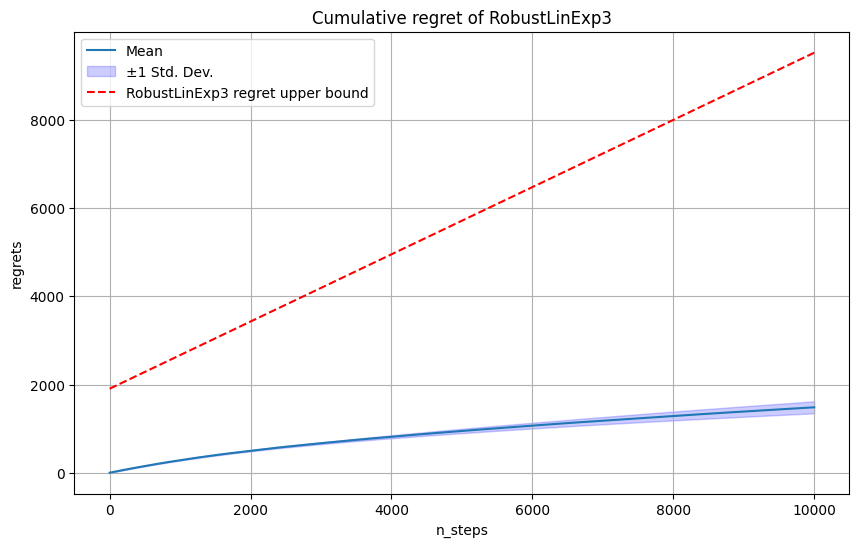

In [4]:
vis.plot_mean_std(
    data=cumulative_regrets, 
    title=f"Cumulative regret of {name}", 
    xlabel="n_steps", 
    ylabel="regrets", 
    baseline=bound_per_timestep,
    baseline_title=f"{name} regret upper bound"
)

## Experiment: StochasticLinearAdversary

In [3]:
# Init Adversary
adv = StochasticLinearAdversary(num_actions=K, context_dim=d, noise_mean=noise_mean, noise_std=noise_std)

# Init Environment
adv_env = AdversarialContextualEnv(adversary=adv, context=ctx)

# Play experiment
num_sim = 100
exp = AdversarialContextualMAB()
(rewards, 
 regrets, 
 avg_rewards, 
 pseudo_regrets, 
 cumulative_regrets, 
 cumulative_pseudo_regrets) = exp.play(agent=ag, environment=adv_env, num_sim=num_sim, horizon=h)

NameError: name 'noise_mean' is not defined

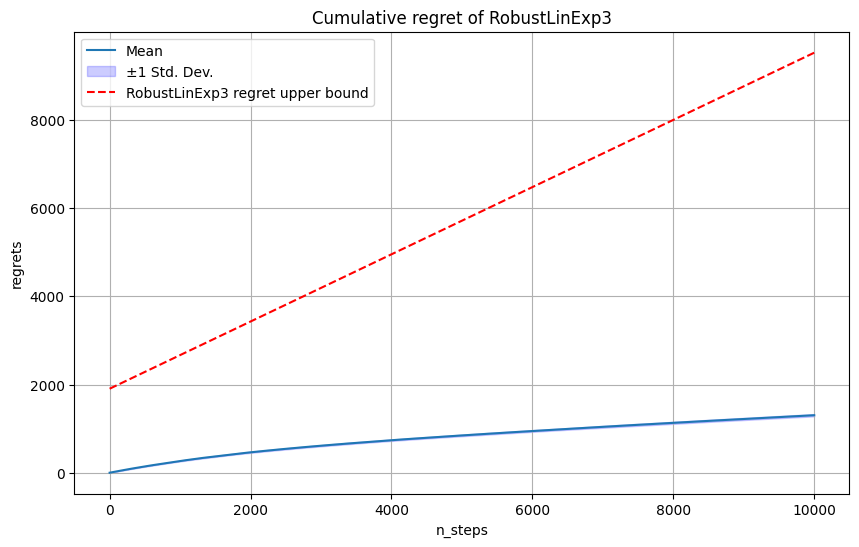

In [6]:
vis.plot_mean_std(
    data=cumulative_regrets, 
    title=f"Cumulative regret of {name}", 
    xlabel="n_steps", 
    ylabel="regrets", 
    baseline=bound_per_timestep,
    baseline_title=f"{name} regret upper bound"
)

## Experiment: Contextual Probabilistic Adversary ##

In [8]:

experiments = {}
ubs = [0.3]
# Play experiment
num_sim = 100
exp = AdversarialContextualMAB()
for ub in ubs:
    # Init Adversary
    adv = ContextualProbabilisticAdversary(K, d, h, eta=lr, gamma=exploration_rate, ub=ub)

    # Init Environment
    adv_env = AdversarialContextualEnv(adversary=adv, context=ctx)
    (rewards,
     regrets,
     avg_rewards,
     pseudo_regrets,
     cumulative_regrets,
     cumulative_pseudo_regrets) = exp.play(agent=ag, environment=adv_env, num_sim=num_sim, horizon=h)
    label = f'p: {ub:}'
    experiments[label] = cumulative_regrets

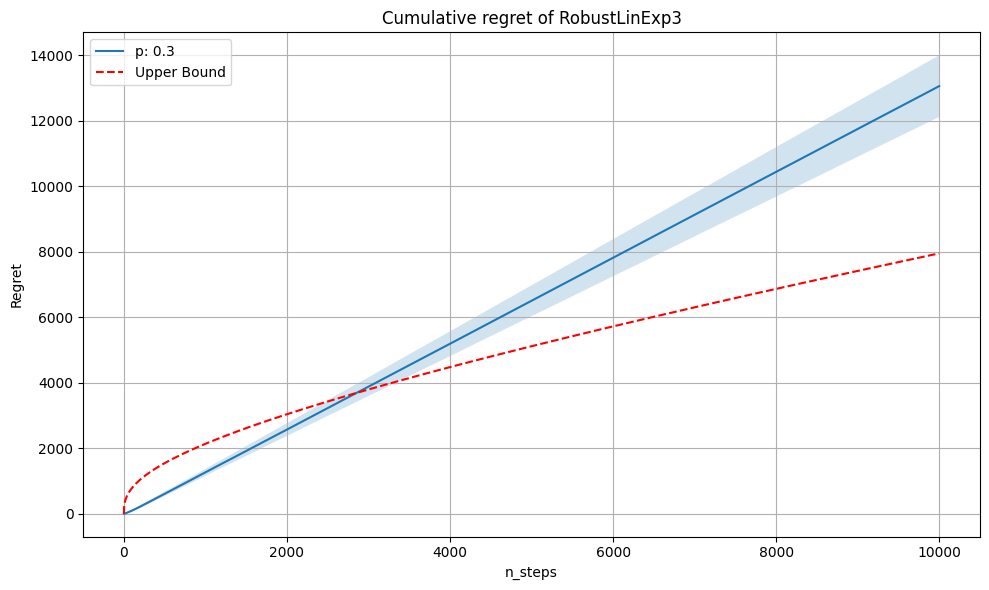

In [9]:
import matplotlib.pyplot as plt
# Plot mean ± std for each experiment
plt.figure(figsize=(10, 6))

for label, values in experiments.items():
    mean_vals = np.mean(values, axis=0)
    std_vals = np.std(values, axis=0)
    timesteps = np.arange(values.shape[1])

    plt.plot(timesteps, mean_vals, label=label)
    plt.fill_between(timesteps, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)

plt.plot(np.arange(len(bound_per_timestep)), bound_per_timestep, linestyle='--', color='red', label='Upper Bound')

# Customize
plt.title(f"Cumulative regret of {name}")
plt.xlabel("n_steps")
plt.ylabel("Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()